目標欄位：PH_decPressureRinse5
有效筆數（val!=0）：17824
殘差門檻（實際異常用，1%/99%，小數第3位）：[-0.105, 0.167]
值域門檻（預測異常用，1%/99%，小數第3位）：[4.53, 8.13]
可評估樣本數（confusion matrix 母體）：17818

— 混淆矩陣（rows=實際, cols=預測）—
               Pred=Anom  Pred=Normal
Actual=Anom            8          268
Actual=Normal        298        17244

實際異常數：306   預測異常數：276


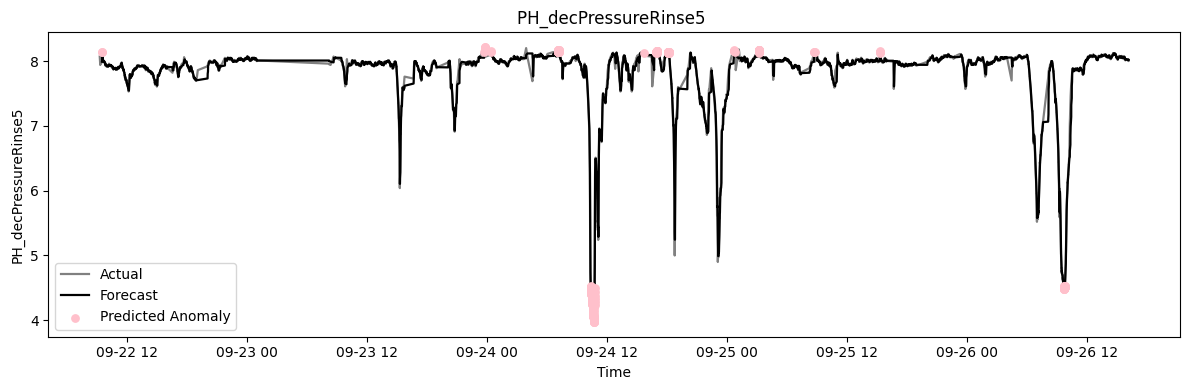

In [ ]:
# -*- coding: utf-8 -*-
# Forecast-then-Detect（單欄位，全班別合併）
# 只標示「預測異常」：yhat 落在值域正常帶之外（1%/99%）
# 圖：Actual=灰線，Forecast=黑線，Predicted anomaly=粉紅點，val=0 用灰色區段
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 參數 =====
FILE = "CP_10s.csv"
VAR  = "PH_decPressureRinse5"   # 你的目標欄位
MA_N = 6                        # 10 分鐘一筆 → 1 小時視窗
CAL_FRAC = 0.70                 # 校準期占比
Q_LOW, Q_HIGH = 0.01, 0.99      # 分位數門檻
ROUND_N = 3                     # 門檻四捨五入小數第 3 位

def parse_t10(series):
    # 優先用 "22SEP2025:09:19:40" 格式，失敗再寬鬆 parse
    s = pd.to_datetime(series, format="%d%b%Y:%H:%M:%S", errors="coerce")
    if s.isna().any():
        s2 = pd.to_datetime(series, errors="coerce")
        s = s.fillna(s2)
    return s

# ===== 1) 讀檔 & 時間 =====
df = pd.read_csv(FILE)
ts_col = next((c for c in ["t10","create_date","timestamp","time","ts"] if c in df.columns), None)
if ts_col is None:
    raise ValueError("找不到時間欄位（t10/create_date/timestamp/time/ts）。")

df["ts"] = parse_t10(df[ts_col])
df = df.dropna(subset=["ts"]).sort_values("ts")

if VAR not in df.columns:
    raise ValueError(f"欄位不存在：{VAR}")

# ===== 2) OFF 與有效值 =====
g = df[["ts", VAR]].copy()
g["val_raw"] = pd.to_numeric(g[VAR], errors="coerce")
g["is_off"]  = (g["val_raw"] == 0)             # 0 視為 OFF
g["val"]     = g["val_raw"].where(~g["is_off"], np.nan)  # OFF→NaN（不進模型，不畫線）
g = g.drop(columns=[VAR])

effective_n = g["val"].notna().sum()
if effective_n == 0:
    raise ValueError(f"{VAR} 沒有 val!=0 的有效資料。")

# ===== 3) 預測（移動平均 → 一步）與殘差 =====
g["yhat"] = g["val"].rolling(MA_N, min_periods=MA_N).mean().shift(1)
g["res"]  = g["val"] - g["yhat"]

# ===== 4) 實際異常（拿來當混淆矩陣的「真實標籤」）=====
# 以殘差的 1%/99%（用前 70% 當校準）→ 這只是用來評估成效，不會畫在圖上
res_valid = g["res"].dropna()
cal_res = res_valid.iloc[: int(len(res_valid)*CAL_FRAC) ] if len(res_valid) >= 20 else res_valid
q_low_res  = cal_res.quantile(Q_LOW)  if not cal_res.empty else np.nan
q_high_res = cal_res.quantile(Q_HIGH) if not cal_res.empty else np.nan
q_low_res_r  = float(np.round(q_low_res,  ROUND_N)) if pd.notna(q_low_res)  else np.nan
q_high_res_r = float(np.round(q_high_res, ROUND_N)) if pd.notna(q_high_res) else np.nan

# 真實標籤：實際異常（只有在 yhat 與 val 都不缺時才可判別）
mask_eval = g["yhat"].notna() & g["val"].notna()
g["y_true_actual_anom"] = False
if pd.notna(q_low_res_r) and pd.notna(q_high_res_r):
    g.loc[mask_eval & ((g["res"] < q_low_res_r) | (g["res"] > q_high_res_r)), "y_true_actual_anom"] = True

# ===== 5) 「預測異常」：yhat 自身超出值域的 1%/99%（校準期、四捨五入）=====
val_valid = g["val"].dropna()
cal_val = val_valid.iloc[: int(len(val_valid)*CAL_FRAC) ] if len(val_valid) >= 20 else val_valid
q_low_val  = cal_val.quantile(Q_LOW)  if not cal_val.empty else np.nan
q_high_val = cal_val.quantile(Q_HIGH) if not cal_val.empty else np.nan
q_low_val_r  = float(np.round(q_low_val,  ROUND_N)) if pd.notna(q_low_val)  else np.nan
q_high_val_r = float(np.round(q_high_val, ROUND_N)) if pd.notna(q_high_val) else np.nan

g["y_pred_anom"] = False
mask_pred = g["yhat"].notna() & (~g["is_off"])  # 必須可預測且非 OFF
if pd.notna(q_low_val_r) and pd.notna(q_high_val_r):
    g.loc[mask_pred & ((g["yhat"] < q_low_val_r) | (g["yhat"] > q_high_val_r)), "y_pred_anom"] = True

# ===== 6) 混淆矩陣與數量（僅在兩種標籤都可得時評估）=====
eval_mask = mask_eval  # 兩者都定義於 yhat/val 不缺的樣本
y_true = g.loc[eval_mask, "y_true_actual_anom"]
y_pred = g.loc[eval_mask, "y_pred_anom"]

TP = int(((y_true == True)  & (y_pred == True)).sum())
FP = int(((y_true == False) & (y_pred == True)).sum())
FN = int(((y_true == True)  & (y_pred == False)).sum())
TN = int(((y_true == False) & (y_pred == False)).sum())
n_actual = int(y_true.sum())
n_pred   = int(y_pred.sum())

print(f"目標欄位：{VAR}")
print(f"有效筆數（val!=0）：{effective_n}")
print(f"殘差門檻（實際異常用，1%/99%，小數第{ROUND_N}位）：[{q_low_res_r}, {q_high_res_r}]")
print(f"值域門檻（預測異常用，1%/99%，小數第{ROUND_N}位）：[{q_low_val_r}, {q_high_val_r}]")
print(f"可評估樣本數（confusion matrix 母體）：{len(y_true)}")
print("\n— 混淆矩陣（rows=實際, cols=預測）—")
print(pd.DataFrame([[TP, FP],[FN, TN]], 
                   index=["Actual=Anom","Actual=Normal"], 
                   columns=["Pred=Anom","Pred=Normal"]))
print(f"\n實際異常數：{n_actual}   預測異常數：{n_pred}")

# ===== 7) 圖（只有預測異常；不儲存檔）=====
# 決定 y 範圍（忽略 NaN）
vmin = np.nanmin([g["val"].min(), g["yhat"].min()])
vmax = np.nanmax([g["val"].max(), g["yhat"].max()])
if not np.isfinite(vmin) or not np.isfinite(vmax):
    vmin, vmax = 0.0, 1.0
pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)
y1, y2 = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(12, 4))
# OFF 灰區
ax.fill_between(g["ts"], y1, y2, where=g["is_off"], alpha=0.15)
# 線
ax.plot(g["ts"], g["val"],  color="0.5", linewidth=1.6, label="Actual")
ax.plot(g["ts"], g["yhat"], color="black", linewidth=1.6, label="Forecast")
# 粉紅點：預測異常（只畫 yhat 點）
mask_pink = g["y_pred_anom"] & g["yhat"].notna()
ax.scatter(g.loc[mask_pink, "ts"], g.loc[mask_pink, "yhat"], s=28, color="pink", label="Predicted Anomaly", zorder=3)

ax.set_title(f"{VAR} ", fontsize=12)
ax.set_xlabel("Time")
ax.set_ylabel(VAR)
ax.legend()
plt.tight_layout()
plt.show()
